# Imports

In [1]:
# index creation
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED, DATETIME
from whoosh.index import create_in
from whoosh.analysis import StemmingAnalyzer, NgramFilter, StopFilter
from whoosh.qparser import MultifieldParser
from whoosh import scoring
import whoosh

# data import
import json

from gensim.models import KeyedVectors
import numpy as np

# Import pretrained word embeddings (Google's Word2Vec)

In [2]:
word2vec_model_path = 'E:/Users/Lucas xD/Downloads/GoogleNews-vectors-negative300.bin'
from gensim.models import KeyedVectors

try: # nich mehrmals in Speicher laden... sind 3gb
    model
except NameError: 
    model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

In [3]:
model.most_similar(positive=['hugo'])
model.most_similar(positive=['boss'])
model.most_similar(positive=['boss'])

[('supremo', 0.6426823735237122),
 ('bosses', 0.6286453604698181),
 ('head_honcho', 0.5850003957748413),
 ('MOTHERWELL_boss', 0.5591158270835876),
 ('WIGAN_boss', 0.5582457184791565),
 ('caretaker_boss', 0.5453289151191711),
 ('honcho', 0.5437785387039185),
 ('boss_Terry_Venables', 0.5429865717887878),
 ('chairman_Theo_Paphitis', 0.5417101383209229),
 ('Bully_Wee_boss', 0.540573239326477)]

In [4]:
# from gensim.models import Word2Vec

# # read the evaluation file, get it at:
# # https://word2vec.googlecode.com/svn/trunk/questions-words.txt
# questions = 'questions-words.txt'
# evals = open(questions, 'r').readlines()
# num_sections = len([l for l in evals if l.startswith(':')])
# print('total evaluation sentences: {} '.format(len(evals) - num_sections))
# # total evaluation sentences: 19544

# # load the pre-trained model of GoogleNews dataset (100 billion words), get it at:
# # https://code.google.com/p/word2vec/#Pre-trained_word_and_phrase_vectors 
# google = Word2Vec.load_word2vec_format(word2vec_model_path, binary=True)
# # test the model accuracy*
# w2v_model_accuracy(google)
# # Total sentences: 7614, Correct: 74.26%, Incorrect: 25.74%


# def w2v_model_accuracy(model):

#     accuracy = model.accuracy(questions)
    
#     sum_corr = len(accuracy[-1]['correct'])
#     sum_incorr = len(accuracy[-1]['incorrect'])
#     total = sum_corr + sum_incorr
#     percent = lambda a: a / total * 100
    
#     print('Total sentences: {}, Correct: {:.2f}%, Incorrect: {:.2f}%'.format(total, percent(sum_corr), percent(sum_incorr)))

# Synonyms generation with a dictionary (WordNet)

In [5]:
# preprocessing
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet

In [6]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

def tag(sentence):
    words = word_tokenize(sentence)
    words = pos_tag(words)
    return words


def pos(tag):
    if tag.startswith('NN'):
        return wordnet.NOUN


def synonyms(word, tag):
    synsets = wordnet.synsets(word, pos(tag))
    if len(synsets) > 1:
        first_syn = synsets[0]  # only take closest match (frequent synonyms)
        lemma_lists = first_syn.lemmas()
        lemmas = [lemma.name()
                  for lemma in lemma_lists if lemma.name() != word]
        return lemmas
    else:
        return []


def synonymIfExists(sentence):
    for (word, t) in tag(sentence):
        if t.startswith('NN'):  # only take nouns
            syns = synonyms(word, t)
            if syns:
                if len(syns) >= 1:
                    yield [word, syns[0]]  # keep only one synonym
                    continue
            yield [word]


def get_synonyms(sentence):
    words = [word for word in synonymIfExists(sentence)]
    single_list = [item for sublist in words for item in sublist]

    return single_list

print(get_synonyms("casual winter cloth"))
print(get_synonyms("fitting tie for a casual meeting"))
print(get_synonyms("summer T-shirt"))
print(get_synonyms("elastic trouser"))
print(get_synonyms("pretty little skirt"))


['winter', 'cloth']
['tie', 'necktie', 'meeting', 'group_meeting']
['summer', 'summertime', 'T-shirt']
['trouser', 'pant']
['skirt']


In [7]:
#################
# Similar words #
#################


def sim_words(word):
    sim_words_arr = []
    try:
        # pretrained or custom w2v model <---- beide dazunehmen
        words = model.most_similar(word)
    except KeyError:  # no similar words found
        return sim_words_arr
    for word in words:
        if word[1] > 0.75:  # cosine similarity must be at least 75%
            sim_words_arr.append(word[0])

    return sim_words_arr


def similarIfExists(sentence):
    for (word, t) in tag(sentence):
        if t.startswith('NN'):
            sim = sim_words(word)
            if sim:
                if len(sim) >= 1:
                    yield [word, sim[0]]  # keep only one
                    continue
        yield [word]


def get_similar_words(sentence):
    words = [word for word in similarIfExists(sentence)]
    single_list = [item for sublist in words for item in sublist]
    return single_list


def add_syns_and_similar_words(sentence):
    syns = get_synonyms(sentence)
    sims = get_similar_words(sentence)
    result = syns + sims

    result = ','.join(set(result))
    return result

print(get_similar_words("pretty little skirt"))
print(get_similar_words("casual winter cloth"))
print(get_similar_words("fitting tie for a casual meeting"))
print(get_similar_words("summer T-shirt"))

print(add_syns_and_similar_words("elastic trouser"))
print(add_syns_and_similar_words("pretty little skirt"))
print(add_syns_and_similar_words("casual winter cloth"))
print(add_syns_and_similar_words("fitting tie for a casual meeting"))
print(add_syns_and_similar_words("summer T-shirt"))

['pretty', 'little', 'skirt', 'skirts']
['casual', 'winter', 'cloth']
['fitting', 'tie', 'for', 'a', 'casual', 'meeting', 'meetings']
['summer', 'spring', 'T-shirt']
elastic,pant,trouser
skirt,pretty,skirts,little
casual,cloth,winter
meetings,fitting,casual,meeting,a,necktie,for,tie,group_meeting
spring,summertime,summer,T-shirt


In [8]:
def preprocess_query(search_term):
        stem = StemmingAnalyzer(stoplist=frozenset([
            'and', 'is', 'it', 'an', 'as', 'at', 'have', 'in', 'yet', 'if',
            'from', 'for', 'when', 'by', 'to', 'you', 'be', 'we', 'that',
            'may', 'not', 'with', 'tbd', 'a', 'on', 'your', 'this', 'of', 'us',
            'will', 'can', 'the', 'or', 'are'
        ]),
                                minsize=3)
        return [token.text for token in stem(search_term)]

In [9]:
print(','.join(preprocess_query('fitting,necktie,tie,for,a,casual,occasional,meeting,coming_together')))
print(','.join(preprocess_query('elastic,pliant,trouser,pant')))

fitt,neckti,tie,casual,occasion,meet,coming_togeth
elast,pliant,trouser,pant


# Training word embeddings with product data (Tensorflow, Keras)

In [16]:
import io
import re
import string
import tensorflow as tf
import tqdm

from tensorflow.keras import Model
from tensorflow.keras.layers import Dot, Embedding, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import numpy as np

## Testing concepts

In [17]:
sentence = "Hooded sweatshirt with logo tape trim"
tokens = list(sentence.lower().split())
print(tokens)

['hooded', 'sweatshirt', 'with', 'logo', 'tape', 'trim']


In [18]:
vocab, index = {}, 1  # start indexing from 1
vocab['<pad>'] = 0  # add a padding token
for token in tokens:
  if token not in vocab:
    vocab[token] = index
    index += 1
vocab_size = len(vocab)
print(vocab)

{'<pad>': 0, 'hooded': 1, 'sweatshirt': 2, 'with': 3, 'logo': 4, 'tape': 5, 'trim': 6}


In [19]:
inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab)

{0: '<pad>', 1: 'hooded', 2: 'sweatshirt', 3: 'with', 4: 'logo', 5: 'tape', 6: 'trim'}


In [20]:
example_sequence = [vocab[word] for word in tokens]
print(example_sequence)

[1, 2, 3, 4, 5, 6]


In [21]:
window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      example_sequence,
      vocabulary_size=vocab_size,
      window_size=window_size,
      negative_samples=0)
print(len(positive_skip_grams))

18


In [22]:
for target, context in positive_skip_grams[:5]:
  print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")

(3, 5): (with, tape)
(5, 4): (tape, logo)
(3, 1): (with, hooded)
(5, 3): (tape, with)
(4, 5): (logo, tape)


In [23]:
# Get target and context words for one positive skip-gram.
target_word, context_word = positive_skip_grams[0]

# Set the number of negative samples per positive context.
num_ns = 4

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class,  # class that should be sampled as 'positive'
    num_true=1,  # each positive skip-gram has 1 positive context class
    num_sampled=num_ns,  # number of negative context words to sample
    unique=True,  # all the negative samples should be unique
    range_max=vocab_size,  # pick index of the samples from [0, vocab_size]
    seed=4,  # seed for reproducibility
    name="negative_sampling"  # name of this operation
)
print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])

tf.Tensor([2 6 0 3], shape=(4,), dtype=int64)
['sweatshirt', 'trim', '<pad>', 'with']


In [24]:
# Add a dimension so you can use concatenation (on the next step).
negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

# Concat positive context word with negative sampled words.
context = tf.concat([context_class, negative_sampling_candidates], 0)

# Label first context word as 1 (positive) followed by num_ns 0s (negative).
label = tf.constant([1] + [0]*num_ns, dtype="int64")

# Reshape target to shape (1,) and context and label to (num_ns+1,).
target = tf.squeeze(target_word)
context = tf.squeeze(context)
label = tf.squeeze(label)

In [25]:
print(f"target_index    : {target}")
print(f"target_word     : {inverse_vocab[target_word]}")
print(f"context_indices : {context}")
print(f"context_words   : {[inverse_vocab[c.numpy()] for c in context]}")
print(f"label           : {label}")

print("target  :", target)
print("context :", context)
print("label   :", label)

target_index    : 3
target_word     : with
context_indices : [5 2 6 0 3]
context_words   : ['tape', 'sweatshirt', 'trim', '<pad>', 'with']
label           : [1 0 0 0 0]
target  : tf.Tensor(3, shape=(), dtype=int32)
context : tf.Tensor([5 2 6 0 3], shape=(5,), dtype=int64)
label   : tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int64)


## Import training data

In [26]:
import json
import pandas as pd
import re
import io

In [27]:
with open(r"E:\Users\Lucas xD\Downloads\Products_Q_US_edited.json", encoding="utf8") as json_file:
    data = json.load(json_file)

In [28]:
df = pd.json_normalize(data)
df.head()

,brand,colors,gender,longDescription,name,productId,shortDescription,sizes,styleName,variants,image,id
0,HUGO,"[{'code': '001', 'name': 'Black', 'link': 'htt...",Men,V-neck Solid Small embossed tonal logo detail ...,Stretch Cotton V-Neck T-Shirt | Dredosos,hbna50261022,This t-shirt by HUGO is crafted from cotton wi...,"[XS, L, M, S, XL, XXL]",,"[{'careInstructionCodes': ['000087', 'B1', 'C0...",https://images.hugoboss.com/is/image/boss/hbna...,0.0
1,BOSS,"[{'code': '001', 'name': 'Black', 'link': 'htt...",Men,Cow skin Basket weave printed texture Tonal sq...,Leather belt with embossed detail,hbna50262032,Upgrade your everyday collection with this tim...,"[34, 38, 40, 42, 44, 30, 32, 36]",,"[{'careInstructionCodes': [], 'colorCode': '00...",https://images.hugoboss.com/is/image/boss/hbna...,1.0
2,BOSS,"[{'code': '001', 'name': 'Black', 'link': 'htt...",Men,Lace-up Derby Italian leather upper Leather li...,Italian Leather Derby Dress Shoe | Prindo,hbna50263062,Crafted from fine Italian calfskin with a prin...,"[6.5, 9, 11, 11.5, 12, 7, 7.5, 8, 8.5, 9.5, 10...",DressShoes,"[{'careInstructionCodes': [], 'colorCode': '00...",https://images.hugoboss.com/is/image/boss/hbna...,2.0
3,BOSS,"[{'code': '001', 'name': 'Black', 'link': 'htt...",Men,A regular fit tuxedo in virgin wool. <b>Jacke...,"Virgin Wool Tuxedo, Regular Fit | Stars/Glamour",hbna50194045,This regular fit tuxedo by BOSS is crafted in ...,"[34R, 42L, 44L, 46L, 48L, 36R, 36S, 38R, 38S, ...",Tuxedos,"[{'careInstructionCodes': ['00', 'B1', 'C0', '...",https://images.hugoboss.com/is/image/boss/hbna...,3.0
4,BOSS,"[{'code': '410', 'name': 'Dark Blue', 'link': ...",Men,A slim-fit suit made from Italian Super 110s v...,"Italian Virgin Wool Suit, Slim Fit | Huge/Genius",hbna50263213,Our best-selling suit just got better with an ...,"[44S, 48L, 42L, 44L, 34R, 36R, 38R, 40R, 40S, ...",Professional,"[{'careInstructionCodes': ['00', 'B1', 'C0', '...",https://images.hugoboss.com/is/image/boss/hbna...,4.0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             2777 non-null   object 
 1   colors            2777 non-null   object 
 2   gender            2777 non-null   object 
 3   longDescription   2777 non-null   object 
 4   name              2777 non-null   object 
 5   productId         2777 non-null   object 
 6   shortDescription  2777 non-null   object 
 7   sizes             2777 non-null   object 
 8   styleName         2777 non-null   object 
 9   variants          2777 non-null   object 
 10  image             2777 non-null   object 
 11  id                2777 non-null   float64
dtypes: float64(1), object(11)
memory usage: 260.5+ KB


In [30]:
df = df.drop(columns=['brand', 'colors', 'gender', 'productId', 'sizes', 'styleName', 'variants', 'image', 'id'])
df.head()

,longDescription,name,shortDescription
0,V-neck Solid Small embossed tonal logo detail ...,Stretch Cotton V-Neck T-Shirt | Dredosos,This t-shirt by HUGO is crafted from cotton wi...
1,Cow skin Basket weave printed texture Tonal sq...,Leather belt with embossed detail,Upgrade your everyday collection with this tim...
2,Lace-up Derby Italian leather upper Leather li...,Italian Leather Derby Dress Shoe | Prindo,Crafted from fine Italian calfskin with a prin...
3,A regular fit tuxedo in virgin wool. <b>Jacke...,"Virgin Wool Tuxedo, Regular Fit | Stars/Glamour",This regular fit tuxedo by BOSS is crafted in ...
4,A slim-fit suit made from Italian Super 110s v...,"Italian Virgin Wool Suit, Slim Fit | Huge/Genius",Our best-selling suit just got better with an ...


In [31]:
df = df.stack().reset_index() # all in one column

In [32]:
df = df.drop(columns=['level_0', 'level_1'])
df.columns = ['sentences']
df.head()

,sentences
0,V-neck Solid Small embossed tonal logo detail ...
1,Stretch Cotton V-Neck T-Shirt | Dredosos
2,This t-shirt by HUGO is crafted from cotton wi...
3,Cow skin Basket weave printed texture Tonal sq...
4,Leather belt with embossed detail


In [33]:
def pre_process(text):
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

In [34]:
df['sentences'] = df['sentences'].apply(lambda x:pre_process(x))
df.head()

,sentences
0,v neck solid small embossed tonal logo detail ...
1,stretch cotton v neck t shirt dredosos
2,this t shirt by hugo is crafted from cotton wi...
3,cow skin basket weave printed texture tonal sq...
4,leather belt with embossed detail


In [35]:
sentences_arr = df['sentences'].tolist()
out = io.open('product_text.txt', 'w', encoding='utf-8')

for sentence in sentences_arr:
  out.write(sentence + "\n")
out.close()

## Preprocessing in one function

In [36]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels


In [37]:
# path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
path_to_file = r"C:\Users\lucas\Documents\Github\BA_Jupyter_Notebook\index_synonyms\product_text.txt"

In [38]:
with open(path_to_file, encoding="utf8") as f: 
  lines = f.read().splitlines()
for line in lines[:5]:
  print(line)

v neck solid small embossed tonal logo detail above hem stretch cotton
stretch cotton v neck t shirt dredosos
this t shirt by hugo is crafted from cotton with a hint of stretch for comfort a small embossed tonal logo detail above the hem completes this v neck style 
cow skin basket weave printed texture tonal square pin buckle logo printed at buckle width in cm 
leather belt with embossed detail


In [39]:
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

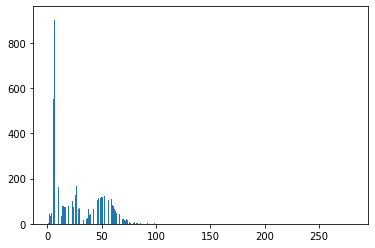

In [40]:
import matplotlib.pyplot as plt

num_words = [len(x.split()) for x in df['sentences'].tolist() if len(x.split()) > 0]
num_words
plt.hist(num_words, bins=500)
plt.show()

In [41]:
# custom standardization function to lowercase the text and remove punctuation & numbers.
def custom_standardization(input_data):
  text_nonum = input_data
  if isinstance(input_data, str):
    text_nonum = text_nonum = re.sub(r'\d+', '', input_data) # remove numbers
  if type(text_nonum) == int or type(text_nonum) == float:
        return ''
  lowercase = tf.strings.lower(text_nonum)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# vocabulary size and number of words in a sequence.
vocab_size = 4096
sequence_length = 50

# text vectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [42]:
vectorize_layer.adapt(text_ds.batch(1024))

In [43]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'a', 'with', 'in', 'fit', 'and', 'the', 'this', 'for', 'by', 'pockets', 'boss', 'to', 'length', 'inches', 'of', 'cm', 'regular', 'slim']


In [44]:
# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(tf.data.AUTOTUNE).map(vectorize_layer).unbatch() # unbatch tut alle arr in arr "abflachen"

In [45]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

8061


In [46]:
for seq in sequences[:5]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 351   59  430  810  244  226   27  166 1337  210   31   24    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] => ['v', 'neck', 'solid', 'small', 'embossed', 'tonal', 'logo', 'detail', 'above', 'hem', 'stretch', 'cotton', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[  31   24  351   59   81   23 3524    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] => ['stretch', 'cotton', 'v', 'neck', 't', 'shirt', 'dredosos', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',

In [47]:

#print(len(targets), len(contexts), len(labels))

NameError: name 'targets' is not defined

In [48]:
def optimize_performance(targets, contexts, labels):
    BATCH_SIZE = 1024
    BUFFER_SIZE = 10000
    dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [49]:
class Word2Vec(Model):
    def __init__(self, vocab_size, embedding_dim, num_ns):
        super(Word2Vec, self).__init__()
        self.target_embedding = Embedding(vocab_size,
                                          embedding_dim,
                                          input_length=1,
                                          name="w2v_embedding")
        self.context_embedding = Embedding(vocab_size,
                                           embedding_dim,
                                           input_length=num_ns+1)
        self.dots = Dot(axes=(3, 2))
        self.flatten = Flatten()

    def call(self, pair):
        target, context = pair
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = self.dots([context_emb, word_emb])
        return self.flatten(dots)


In [51]:
embedding_dims = [8, 16, 32, 64, 128, 254]
epochs = [10, 20, 30, 40, 100]
neg_samples = [4, 9, 19]
for embedding_dim in embedding_dims:
    for epoch_num in epochs:
        for num_ns in neg_samples:
            name = "{}-embeds-{}-epochs-{}-ns".format(embedding_dim, epoch_num, num_ns)

            targets, contexts, labels = generate_training_data(sequences=sequences,window_size=2,num_ns=num_ns,vocab_size=vocab_size)
            dataset = optimize_performance(targets, contexts, labels)

            word2vec = Word2Vec(vocab_size, embedding_dim, num_ns)
            word2vec.compile(optimizer='adam',
                            loss=tf.keras.losses.CategoricalCrossentropy(
                                from_logits=True),
                            metrics=['accuracy'])
            tensorboard_callback = tf.keras.callbacks.TensorBoard(
                log_dir="logs/{}".format(name))
            word2vec.fit(dataset, epochs=epoch_num,
                        validation_split=0.2,
                        callbacks=[tensorboard_callback])


100%|██████████| 8061/8061 [00:06<00:00, 1250.97it/s]


ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>]

In [99]:
from tensorboard.plugins import projector
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [100]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [101]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip <PAD>.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [102]:
index2word = dict(enumerate(list(inverse_vocab)))
word2index = {v: k for k, v in index2word.items()}

text_vector_ds

<_UnbatchDataset shapes: (10,), types: tf.int64>

In [103]:
def find_closest(embeds, word, n=3): # n is for "n closest words"
  n = n + 1 # This is becuse the most similar word is definatly that word itself. like the most similar word for "apple" is "apple". so we should look for top n+1 words
  main_vec = embeds(word2index[word])

  similarities = -tf.keras.losses.cosine_similarity(embeds.embeddings, main_vec)
  top_n = tf.math.top_k(similarities, n).indices
  words = [index2word[i] for i in top_n.numpy()]

  return words[0:], tf.math.top_k(similarities, 3)[0][1]

In [109]:
# target = word2vec.target_embedding
target = word2vec.get_layer('w2v_embedding')
res, sim = find_closest(target, 'glasses')
print('closest: ', res)
print('top similarity: ', sim.numpy())

closest:  ['glasses', 'shades', 'these', 'sunglasses']
top similarity:  0.83597505


In [62]:
word2vec.summary()

Model: "word2_vec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
w2v_embedding (Embedding)    multiple                  262144    
_________________________________________________________________
embedding (Embedding)        multiple                  262144    
_________________________________________________________________
dot (Dot)                    multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
Total params: 524,288
Trainable params: 524,288
Non-trainable params: 0
_________________________________________________________________


# TF-IDF most common words

## Preprocessing

In [63]:
import json
import pandas as pd

In [64]:
def pre_process(text):
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)

    text = add_syns_and_similar_words(text)
    
    return text

In [67]:
# with open(r"E:\Users\Lucas xD\Downloads\Products_Q_US_edited.json", encoding="utf8") as json_file:
#     data = json.load(json_file)

# df = pd.json_normalize(data)
# df['name'] = df['name'].apply(lambda x:pre_process(x))
# df.to_csv('prods_w_syn_sim.csv', index=False)
# df_names.head(3)

In [68]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# n_features = 1000

# corpus = sentences_arr
# vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
#                             max_features=n_features, stop_words='english')
# X = vectorizer.fit_transform(corpus)
# print(vectorizer.get_feature_names()[:10])

# print(X.shape)


# Create Schema with analyzers & filters (Whoosh)

In [69]:
df_syn = pd.read_csv('prods_w_syn_sim.csv')
df_syn.head() 
for row in df_syn['name'].iloc[:100]:
    print(row)

volt,vs,neck,shirt,cervix,t,dredosos,shirts,cotton_fiber,v,cotton,thymine,stretch
embossed,belt,leather,belts,detail,item,with
dress,frock,dresses,prindo,italian,derby,shoes,shoe,leather
fit,wool,glamour,woolen,regular,virgin,star,tuxedo,stars
fit,wool,slim,suits,woolen,suit_of_clothes,italian,virgin,genius,huge,suit,mastermind
metal,check,belt,tab,detailed,leather,belts,metallic_element,connio
shift,dress,sleeveless,frock,wool,dresses,woolen,italian,in,displacement,shifts,stretch
wool,woolen,jackets,narrow,jacket,lapels,with,stretch
and,gifts,trimness,gunmetal,hardware,suspenders,trim,leather,boxed,gift,with
wool,woolen,blazer,peak,extremum,lapels,with,stretch
curved,wool,lapels,woolen,blazer,with,stretch
fit,soft,vs,shirt,regular,tantrum,volt,neck,cervix,t,in,shirts,cotton_fiber,v,cotton,thymine
pants,fit,cropped,slim,trousers,bloomers,tantrum
wool,leg,woolen,bloomers,boot,italian,virgin,pants,in,trousers,stretch
necktie,tie,silk,italian
shirts,dress,frock,dresses,shirt,cotton_fiber,

In [70]:
schema = Schema(id=ID(stored=True),
                name=TEXT(analyzer=StemmingAnalyzer() | NgramFilter(minsize=2, maxsize=4) | StopFilter(), field_boost=3.0, stored=True),
                brand=TEXT(),
                gender=TEXT(),
                longDescription=TEXT(analyzer=StemmingAnalyzer() | NgramFilter(minsize=2, maxsize=4) | StopFilter()),
                shortDescription=TEXT(analyzer=StemmingAnalyzer() | NgramFilter(minsize=2, maxsize=4) | StopFilter()),
                productId=TEXT(),
                sizes=TEXT(),
                styleName=TEXT(),
                colors=TEXT(),
                image=TEXT(),
                variants=TEXT(),
                )

# Create the index

In [71]:
index_path = './w2v_index'

In [72]:
create_new_index = True
if(create_new_index):
    index = create_in(index_path, schema)
else:    
    index = whoosh.index.open_dir(index_path)

writer = index.writer()

In [73]:
for num, doc in df_syn.iterrows():
    writer.add_document(
            brand=str(doc['brand']),
            colors=str(doc['colors']),
            gender=str(doc['gender']),
            longDescription=str(doc['longDescription']),
            name=str(doc['name']),
            productId=str(doc['productId']),
            shortDescription=str(doc['shortDescription']),
            sizes=str(doc['sizes']),
            styleName=str(doc['styleName']),
            variants=str(doc['variants']),
            image=str(doc['image']),
            id=str(doc['id'])
    )
         
writer.commit()

# Testing the index

In [74]:

use_synonyms = True

search_term = "wintertime"

if(use_synonyms):
    try:
        similarity_list = model.most_similar(search_term, topn=1)
        similar_words = [sim_tuple[0] for sim_tuple in similarity_list]
    except KeyError:
        similar_words = []
    keywords = " OR ".join([search_term] + similar_words)

    print("Results with Word2Vec:")
    print(f"Similar words used: {similar_words}")
    with index.searcher(weighting=scoring.TF_IDF()) as searcher:
        query = MultifieldParser(["name", "longDescription", 'shortDescription'], index.schema).parse(keywords)
        results = searcher.search(query)
        for docnum, score in results.items():
            print(docnum, score)
        print(results)
else:
    keywords  = search_term

# results = []



print("________________________\n")
print("Results without Word2Vec:")
with index.searcher(weighting=scoring.TF_IDF()) as searcher:
    query = MultifieldParser(["name", "longDescription", "shortDescription"], index.schema).parse(search_term)
    results = searcher.search(query)
    for docnum, score in results.items():
        print(docnum, score)
    for doc in results:
        print(doc)

Results with Word2Vec:
Similar words used: ['summertime']
1344 33.30499334186929
1871 33.30499334186929
2057 33.30499334186929
<Top 3 Results for Or([And([Term('name', 'wint'), Term('name', 'inte'), Term('name', 'nter'), Term('name', 'tert'), Term('name', 'erti'), Term('name', 'rtim')]), And([Term('longDescription', 'wint'), Term('longDescription', 'inte'), Term('longDescription', 'nter'), Term('longDescription', 'tert'), Term('longDescription', 'erti'), Term('longDescription', 'rtim')]), And([Term('shortDescription', 'wint'), Term('shortDescription', 'inte'), Term('shortDescription', 'nter'), Term('shortDescription', 'tert'), Term('shortDescription', 'erti'), Term('shortDescription', 'rtim')]), And([Term('name', 'summ'), Term('name', 'umme'), Term('name', 'mmer'), Term('name', 'mert'), Term('name', 'erti'), Term('name', 'rtim')]), And([Term('longDescription', 'summ'), Term('longDescription', 'umme'), Term('longDescription', 'mmer'), Term('longDescription', 'mert'), Term('longDescripti